### a-) Reading the data, choosing the distance measure and preprocessing ###

In [93]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt


In [94]:
df=pd.read_excel('/Users/boraguzel/Downloads/Wisconsin_Diagnostic_Breast_Cancer.xlsx')

In [95]:
df.head(5) #To see the columns and the data we are working with.

,Radius,Texture,Perimeter,Area,Smoothness,Compactness,Concavity,Concave Points,Symmetry,Fractal Dimension,Diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,1
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,1
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,1
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,1


In [96]:
df.info() #To check if there are any null values in data and incorrect Dtypes if there are any.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Radius             569 non-null    float64
 1   Texture            569 non-null    float64
 2   Perimeter          569 non-null    float64
 3   Area               569 non-null    float64
 4   Smoothness         569 non-null    float64
 5   Compactness        569 non-null    float64
 6   Concavity          569 non-null    float64
 7   Concave Points     569 non-null    float64
 8   Symmetry           569 non-null    float64
 9   Fractal Dimension  569 non-null    float64
 10  Diagnosis          569 non-null    int64  
dtypes: float64(10), int64(1)
memory usage: 49.0 KB


We should use min-max normalization in our data to interfere any scaling error.

In [97]:
def min_max_normalize(column):   #Function for min max normalization
    min_val = min(column)
    max_val = max(column)
    return [(x - min_val) / (max_val - min_val) for x in column]
for col in ['Radius', 'Texture', 'Perimeter', 'Area', 'Smoothness', 
            'Compactness', 'Concavity', 'Concave Points', 'Symmetry', 
            'Fractal Dimension']:
    df[col] = min_max_normalize(df[col])
df.head(5)

,Radius,Texture,Perimeter,Area,Smoothness,Compactness,Concavity,Concave Points,Symmetry,Fractal Dimension,Diagnosis
0,0.521037,0.022658,0.545989,0.363733,0.593753,0.792037,0.703140,0.731113,0.686364,0.605518,1
1,0.643144,0.272574,0.615783,0.501591,0.289880,0.181768,0.203608,0.348757,0.379798,0.141323,1
2,0.601496,0.390260,0.595743,0.449417,0.514309,0.431017,0.462512,0.635686,0.509596,0.211247,1
3,0.210090,0.360839,0.233501,0.102906,0.811321,0.811361,0.565604,0.522863,0.776263,1.000000,1
4,0.629893,0.156578,0.630986,0.489290,0.430351,0.347893,0.463918,0.518390,0.378283,0.186816,1


In [98]:
def Eucledian(point,neighborhood):  #We choose Eucledian as distance measure
    distance=np.sqrt(np.sum((point-neighborhood)**2))
    return distance


### b-) KNN classifier and error rates for k=(1,2,3,....,20) ###

In [99]:
def simple_random_indices(n):
    indices = list(range(n))
    shuffled = []
    while indices:
        # Get current time in nanoseconds
        t = time.time_ns()
        
        # Use modulo to find a position based on the current time
        pos = t % len(indices)
        
        # Remove the element at pos and add it to shuffled list
        element = indices.pop(pos)
        shuffled.append(element)
    
    return shuffled


num_samples = len(df)
indices = simple_random_indices(num_samples)

# Split 80%-20%
train_size = int(0.8 * num_samples)
train_indices = indices[:train_size]
test_indices = indices[train_size:]

train_set = df.iloc[train_indices].reset_index(drop=True)
test_set = df.iloc[test_indices].reset_index(drop=True)

In [100]:
# For training data
X_train = train_set.drop(columns=['Diagnosis'])  # Drop the label column to get features
y_train = train_set['Diagnosis']  # Extract the label column

# For testing data
X_test = test_set.drop(columns=['Diagnosis'])  # Drop the label column to get features
y_test = test_set['Diagnosis']  # Extract the label column


In [101]:
def KNN_classification(X_train, y_train, X_test, k, Eucledian):
    predictions = []
    for point in X_test.values:
        distances = []
        for i in range(len(X_train)):
            # Convert the i-th training row to a numpy array
            train_row = X_train.iloc[i].values
            # Compute distance
            distance = Eucledian(point, train_row)
            distances.append((distance, y_train[i]))
        
        # Sort by distance
        distances.sort(key=lambda x: x[0])
        
        # Get the labels of the k-nearest neighbors
        k_nearest_labels = [distances[j][1] for j in range(k)]
        
        # Majority vote
        if k_nearest_labels.count(1) > k_nearest_labels.count(0):
            prediction = 1
        else:
            prediction = 0
        
        predictions.append(prediction)
    
    return predictions


In [102]:
train_errors = []
test_errors = []
for k in range(1,21):
    y_pred_train = KNN_classification(X_train,y_train,X_train,k,Eucledian);
    train_correct = 0
    for i in range(len(y_train)):
        if y_train[i] == y_pred_train[i]:
            train_correct += 1
    train_error_rate = 1 - train_correct/len(y_train)
    train_errors.append(train_error_rate)
    
    y_pred_test = KNN_classification(X_train, y_train, X_test, k, Eucledian)
    test_correct = 0
    for i in range(len(y_test)):
        if y_test[i] == y_pred_test[i]:
            test_correct += 1


    test_error_rate = 1 - test_correct / len(y_test)
    test_errors.append(test_error_rate)

    


In [103]:
train_errors = []
test_errors = []

for k in k_range:
            y_pred_train = KNN_classification(X_train, y_train, X_train, k, Eucledian)
            train_error_rate = calculate_error_rate(y_pred_train, y_train)

            y_pred_test = KNN_classification(X_train, y_train, X_test, k, Eucledian)
            test_error_rate = calculate_error_rate(y_pred_test, y_test)
            
            train_errors.append(train_error_rate)
            test_errors.append(test_error_rate)

### c-) Choosing the k value ###

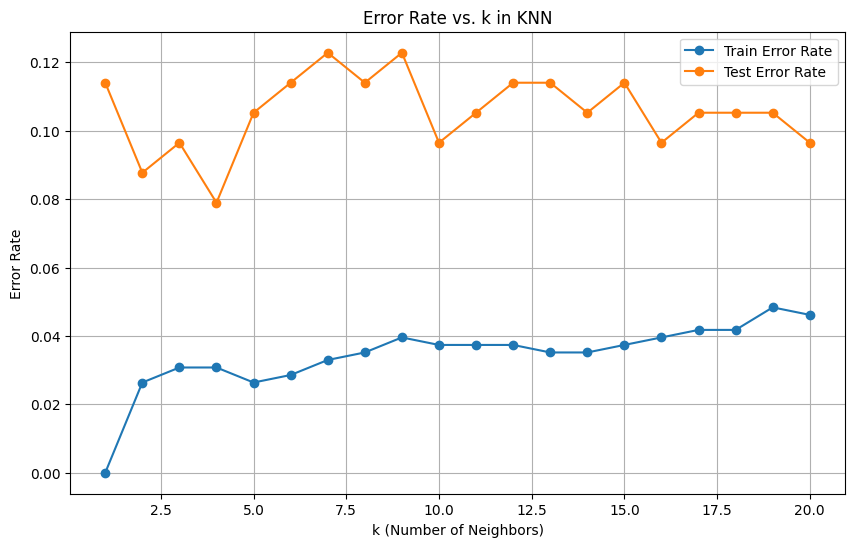

In [104]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), train_errors, label="Train Error Rate", marker='o')
plt.plot(range(1, 21), test_errors, label="Test Error Rate", marker='o')
plt.xlabel("k (Number of Neighbors)")
plt.ylabel("Error Rate")
plt.title("Error Rate vs. k in KNN")
plt.legend()
plt.grid()
plt.show()

### d-) 5-folds cross-validation ###

In [106]:
def calculate_error_rate(predictions, actual_labels):
    return 1 - np.mean(np.array(predictions) == actual_labels)

def k_fold_cross_validation(df, k_range, Eucledian, simple_random_indices, KNN_classification):
    num_samples = len(df)
    indices = simple_random_indices(num_samples)
    fold_size = num_samples // 5
    results = []

    for i in range(5):
        start = i * fold_size
        end = (i + 1) * fold_size if i != 4 else num_samples
        test_indices = indices[start:end]
        train_indices = indices[:start] + indices[end:]
        
        train_set = df.iloc[train_indices].reset_index(drop=True)
        test_set = df.iloc[test_indices].reset_index(drop=True)

        X_train = train_set.drop(columns=['Diagnosis'])
        y_train = train_set['Diagnosis']
        X_test = test_set.drop(columns=['Diagnosis'])
        y_test = test_set['Diagnosis']
        
        train_errors = []
        test_errors = []

        for k in k_range:
            y_pred_train = KNN_classification(X_train, y_train, X_train, k, Eucledian)
            train_error_rate = calculate_error_rate(y_pred_train, y_train)

            y_pred_test = KNN_classification(X_train, y_train, X_test, k, Eucledian)
            test_error_rate = calculate_error_rate(y_pred_test, y_test)
            
            train_errors.append(train_error_rate)
            test_errors.append(test_error_rate)
        
        # Finding the k value with the minimum test error
        min_test_error_idx = np.argmin(test_errors)
        best_k = k_range[min_test_error_idx]
        best_test_error = test_errors[min_test_error_idx]
        best_train_error = train_errors[min_test_error_idx]
        
        # Save results for this fold
        results.append({
            'Fold': i + 1,
            'Best k': best_k,
            'Train Error Rate': best_train_error,
            'Test Error Rate': best_test_error
        })
        
    # Return results as a DataFrame for better visualization
    result_df = pd.DataFrame(results)
    return result_df

# Assuming df is your DataFrame and the last column is the target
k_range = range(1, 21)  # Range of k values to test
results_table = k_fold_cross_validation(df, k_range, Eucledian, simple_random_indices, KNN_classification)
results_table

,Fold,Best k,Train Error Rate,Test Error Rate
0,1,7,0.050439,0.026549
1,2,4,0.039474,0.053097
2,3,10,0.037281,0.079646
3,4,7,0.046053,0.053097
4,5,5,0.050885,0.017094


In [110]:
def KNN_modified(X_train, y_train, X_test, k, Eucledian):
    predictions = []
    for point in X_test.values:
        distances = []
        for i in range(len(X_train)):
            # Convert the i-th training row to a numpy array
            train_row = X_train.iloc[i].values
            # Compute distance
            distance = Eucledian(point, train_row)
            distances.append((distance, y_train[i]))
        
        # Sort by distance
        distances.sort(key=lambda x: x[0])
        
        # Calculate the weights
        nearest_distances = [distances[i][0] for i in range(k)]
        nearest_labels = [distances[i][1] for i in range(k)]

        # Calculate weights
        d_max = max(nearest_distances)
        d_min = min(nearest_distances)
        weights = [(d_max - d) / (d_max - d_min) if d != d_min else 1 for d in nearest_distances]

        # Weighted voting
        label_votes = {}
        for i in range(k):
            label = nearest_labels[i]
            weight = weights[i]
            if label in label_votes:
                label_votes[label] += weight
            else:
                label_votes[label] = weight

        # Determine the label with the maximum weighted vote
        predictions.append(max(label_votes, key=label_votes.get))
    return predictions
            
            
            
        